In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
cbr1krr = pd.read_csv('cbr1kr.csv')
hayabusa = pd.read_csv('hayabusa.csv')

cbr = cbr1krr.to_numpy()
haya = hayabusa.to_numpy()

cbr_rpm_Nm = cbr[:,[0,4]]

In [118]:
# constants
mass = 500 #kg
wheel_rad = .3 #m
rear_weight = .55 #fraction out of 1
tire_mu = .3
final_drive = 3
CG_height = .4 #m
Coef_drag = np.float64(0.4)
frontal_A = np.float64(1.4) #m^2
Rho = np.float64(1.204) # kg/m^3
wheel_base = 1.8 #m
primary_reduction = 1.717
cbr_gears = np.array([2.286, 1.778, 1.5, 1.333, 1.214, 1.138])
gear = cbr_gears * primary_reduction

In [119]:
# top_speed_mph = 100
# top_speed_mps = top_speed_mph * .44704 #conversion from mph to m/s

# final_drive_ratios = np.linspace(1,8,80)
# top_speed_rpm = np.zeros_like(final_drive_ratios)

# for fd_idx, fd_val in enumerate(final_drive_ratios):
#     top_speed_rpm[fd_idx] = top_speed_mps / (2 * np.pi * wheel_rad) * fd_val * gear[5] * 60

# def final_drive_for_top_speed(top_speed_mph):
#     top_speed_mps = top_speed_mph * .44704
#     final_drive_ratio = 13000 / 60 / gear[5] * .6 * np.pi / top_speed_mps
#     return final_drive_ratio

# def top_speed_for_final_drive(final_drive): # mph
#     return 13000 / final_drive / gear[5] / 60 * .6 * np.pi / .44704
# # plt.plot(final_drive_ratios, top_speed_rpm)

In [120]:
def rpm_for_speed_gear(speed, g, fd = final_drive, WR = wheel_rad): #m/s and an int 0 - 5 for 1 - 6 gears
    revs = speed / (2 * WR * np.pi) * fd * gear[g] * 60
    return min(revs, 12800)

def calc_thrust(t, g, FD = final_drive, WR = wheel_rad):
    return t * gear[g] * FD / WR

def calc_drag(v, rho = Rho, FA = frontal_A, Cd = Coef_drag):
    v_squared = v * v
    return np.float64(v_squared * rho * Cd * FA * 0.5)

def calc_rear_tire_NL(accel, CG = CG_height, m = mass, wb = wheel_base, rw = rear_weight):
    return ((m * CG) / wb * accel) + (m * rw)

def calc_traction(rear_NL, thrust, mu = tire_mu): # add tire model for mu later instead of constant
    return min(rear_NL * 9.8 * mu, thrust)

def calc_accel(traction, drag, m = mass):
    return (traction - drag) / m

def speed_for_rpm_gear(rpm, g, FD = final_drive, WR = wheel_rad):
    return rpm / FD / gear[g] * (2* WR * np.pi) / 60

def cbr_torque_for_rpm(rpm):
    term1 = np.float64(-0.000002458755 * (rpm*rpm))
    term2 = np.float64(0.0489652485446 * rpm)
    return np.float64(term1 + term2 - 129.1573667711599)

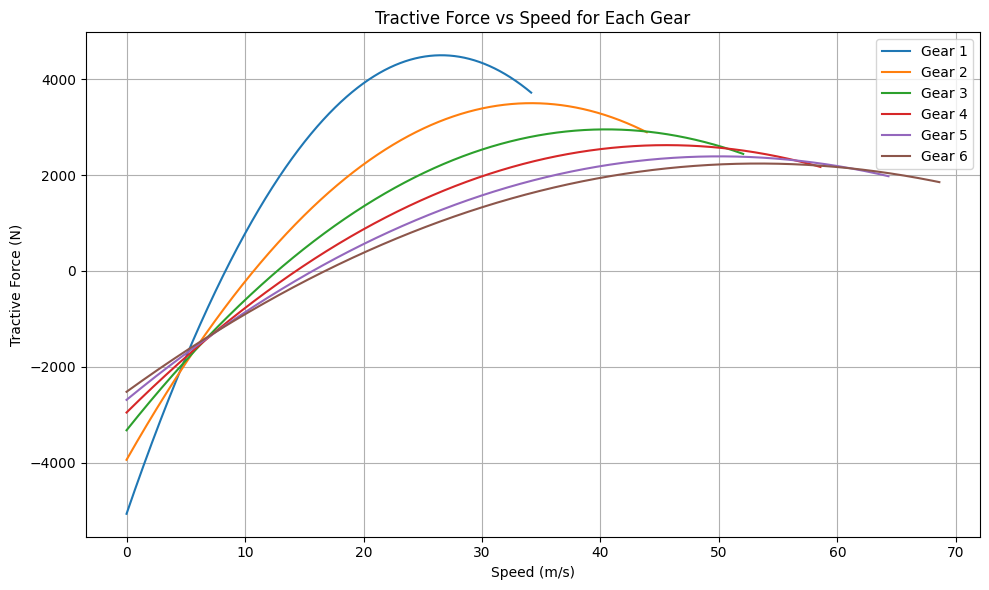

In [121]:
#shift point finder
rpms = np.linspace(0,12800,12800)
tractive_forces = [np.zeros([12800,2]) for _ in range(6)]
for g in range(6):
    for i,r in enumerate(rpms):
        tractive_forces[g][i,0] = speed_for_rpm_gear(r,g)
        # torque = np.interp(r, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque = cbr_torque_for_rpm(r)
        tractive_forces[g][i,1] = calc_thrust(torque,g)

labels = [f"Gear {g+1}" for g in range(6)]

# Plotting
plt.figure(figsize=(10, 6))

for g in range(6):
    if tractive_forces[g].any():  # Skip if array is all zeros (not computed)
        x = tractive_forces[g][:, 0]  # speed
        y = tractive_forces[g][:, 1]  # tractive force
        plt.plot(x, y, label=labels[g])

plt.xlabel('Speed (m/s)')  # Adjust units as appropriate
plt.ylabel('Tractive Force (N)')
plt.title('Tractive Force vs Speed for Each Gear')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
#accel calc
time = np.linspace(0,60,6001, dtype = np.float64)
dt = .01 #sec
vel = np.zeros_like(time, dtype = np.float64)
pos = np.zeros_like(time)
rpm = np.zeros_like(time, dtype = np.float64)
torque = np.zeros_like(time)
thrust = np.zeros_like(time)
drag = np.zeros_like(time)
rear_NL = np.zeros_like(time)
accel = np.zeros_like(time)
traction = np.zeros_like(time)

g = 0 # first gear 0 indexed
shift_rpm = np.float64(12800)
time_since_shift = 1 #sec, not 0 bc dont want to set 0 torque from launch
shift_time = .2
launch_rpm = np.float64(10000)

prev_accel = 0

for i, t in enumerate(time[:-1]):
    vel[i] = vel[i-1] + (accel[i-1] * dt)
    pos[i] = pos[i-1] + (vel[i-1] * dt)
    rpm[i] = rpm_for_speed_gear(vel[i], g)

    if rpm[i] > shift_rpm and (g < 5):
        g += 1
        time_since_shift = 0
        # print("shifted")

    if time_since_shift < shift_time:
        torque[i] = 0
    else:
        # torque[i] = np.interp(rpm[i], cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque[i] = cbr_torque_for_rpm(rpm[i])

    if (rpm[i] < launch_rpm) and g == 0:
        # torque[i] = np.interp(launch_rpm, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque[i] = cbr_torque_for_rpm(launch_rpm)
        rpm[i] = launch_rpm

    thrust[i] = calc_thrust(torque[i], g)
    drag[i] = calc_drag(vel[i])

    rear_NL[i] = calc_rear_tire_NL(prev_accel)
    traction[i] = calc_traction(rear_NL[i], thrust[i])
    accel[i] = calc_accel(traction[i], drag[i])
    print(i, vel[i], drag[i], accel[i])
    prev_accel = accel[i]


    time_since_shift += dt

0 0.0 0.0 1.617
1 0.01617 8.814639556799999e-05 2.6734398237072092
2 0.042904398237072094 0.0006205662442713078 3.3636461103562216
3 0.07654085934063432 0.001975018581456965 3.814578175395568
4 0.11468664109459 0.004434148005630951 4.10918220629576
5 0.1557784631575476 0.008180867301266185 4.301649346378627
6 0.19879495662133387 0.01332279185238566 4.427384260716999
7 0.24306879922850386 0.01991787256331533 4.509517881256646
8 0.2881639780410703 0.027993931784422 4.563162361224107
9 0.33379560165331135 0.03756174308164536 4.598190952513586
10 0.3797775111784472 0.04862314055991344 4.621054176027757
11 0.42598805293872477 0.061175757658628774 4.635966376822817
12 0.47234771670695297 0.07521564065003503 4.645680934909607
13 0.518804526056049 0.09073859089470418 4.651996733625821
14 0.5653244933923072 0.10774078182740308 4.6560890510718815
15 0.6118853839030259 0.1262189831092738 4.6587257420674115
16 0.6584726413237001 0.14617058627462462 4.6604084769781595
17 0.7050767260934817 0.167593

In [123]:
def plot_simulation_results(time, vel, pos, rpm, torque, thrust, drag, rear_NL, accel, traction):
    fig, axs = plt.subplots(5, 2, figsize=(15, 18))
    axs = axs.flatten()

    axs[0].plot(time, vel*2.23694)
    axs[0].set_title("Velocity (mph)")
    axs[0].set_ylabel("mph")

    axs[1].plot(time, pos)
    axs[1].set_title("Position (m)")
    axs[1].set_ylabel("m")

    axs[2].plot(time, rpm)
    axs[2].set_title("Engine RPM")
    axs[2].set_ylabel("RPM")

    axs[3].plot(time, torque)
    axs[3].set_title("Engine Torque")
    axs[3].set_ylabel("Nm")

    axs[4].plot(time, thrust)
    axs[4].set_title("Thrust")
    axs[4].set_ylabel("N")

    axs[5].plot(time, drag)
    axs[5].set_title("Aerodynamic Drag")
    axs[5].set_ylabel("N")

    axs[6].plot(time, rear_NL)
    axs[6].set_title("Rear Normal Load")
    axs[6].set_ylabel("N")

    axs[7].plot(time, accel)
    axs[7].set_title("Acceleration")
    axs[7].set_ylabel("m/s²")

    axs[8].plot(time, traction)
    axs[8].set_title("Available Traction")
    axs[8].set_ylabel("N")

    # Empty plot to keep layout clean
    axs[9].axis('off')

    for ax in axs[:9]:
        ax.set_xlabel("Time (s)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


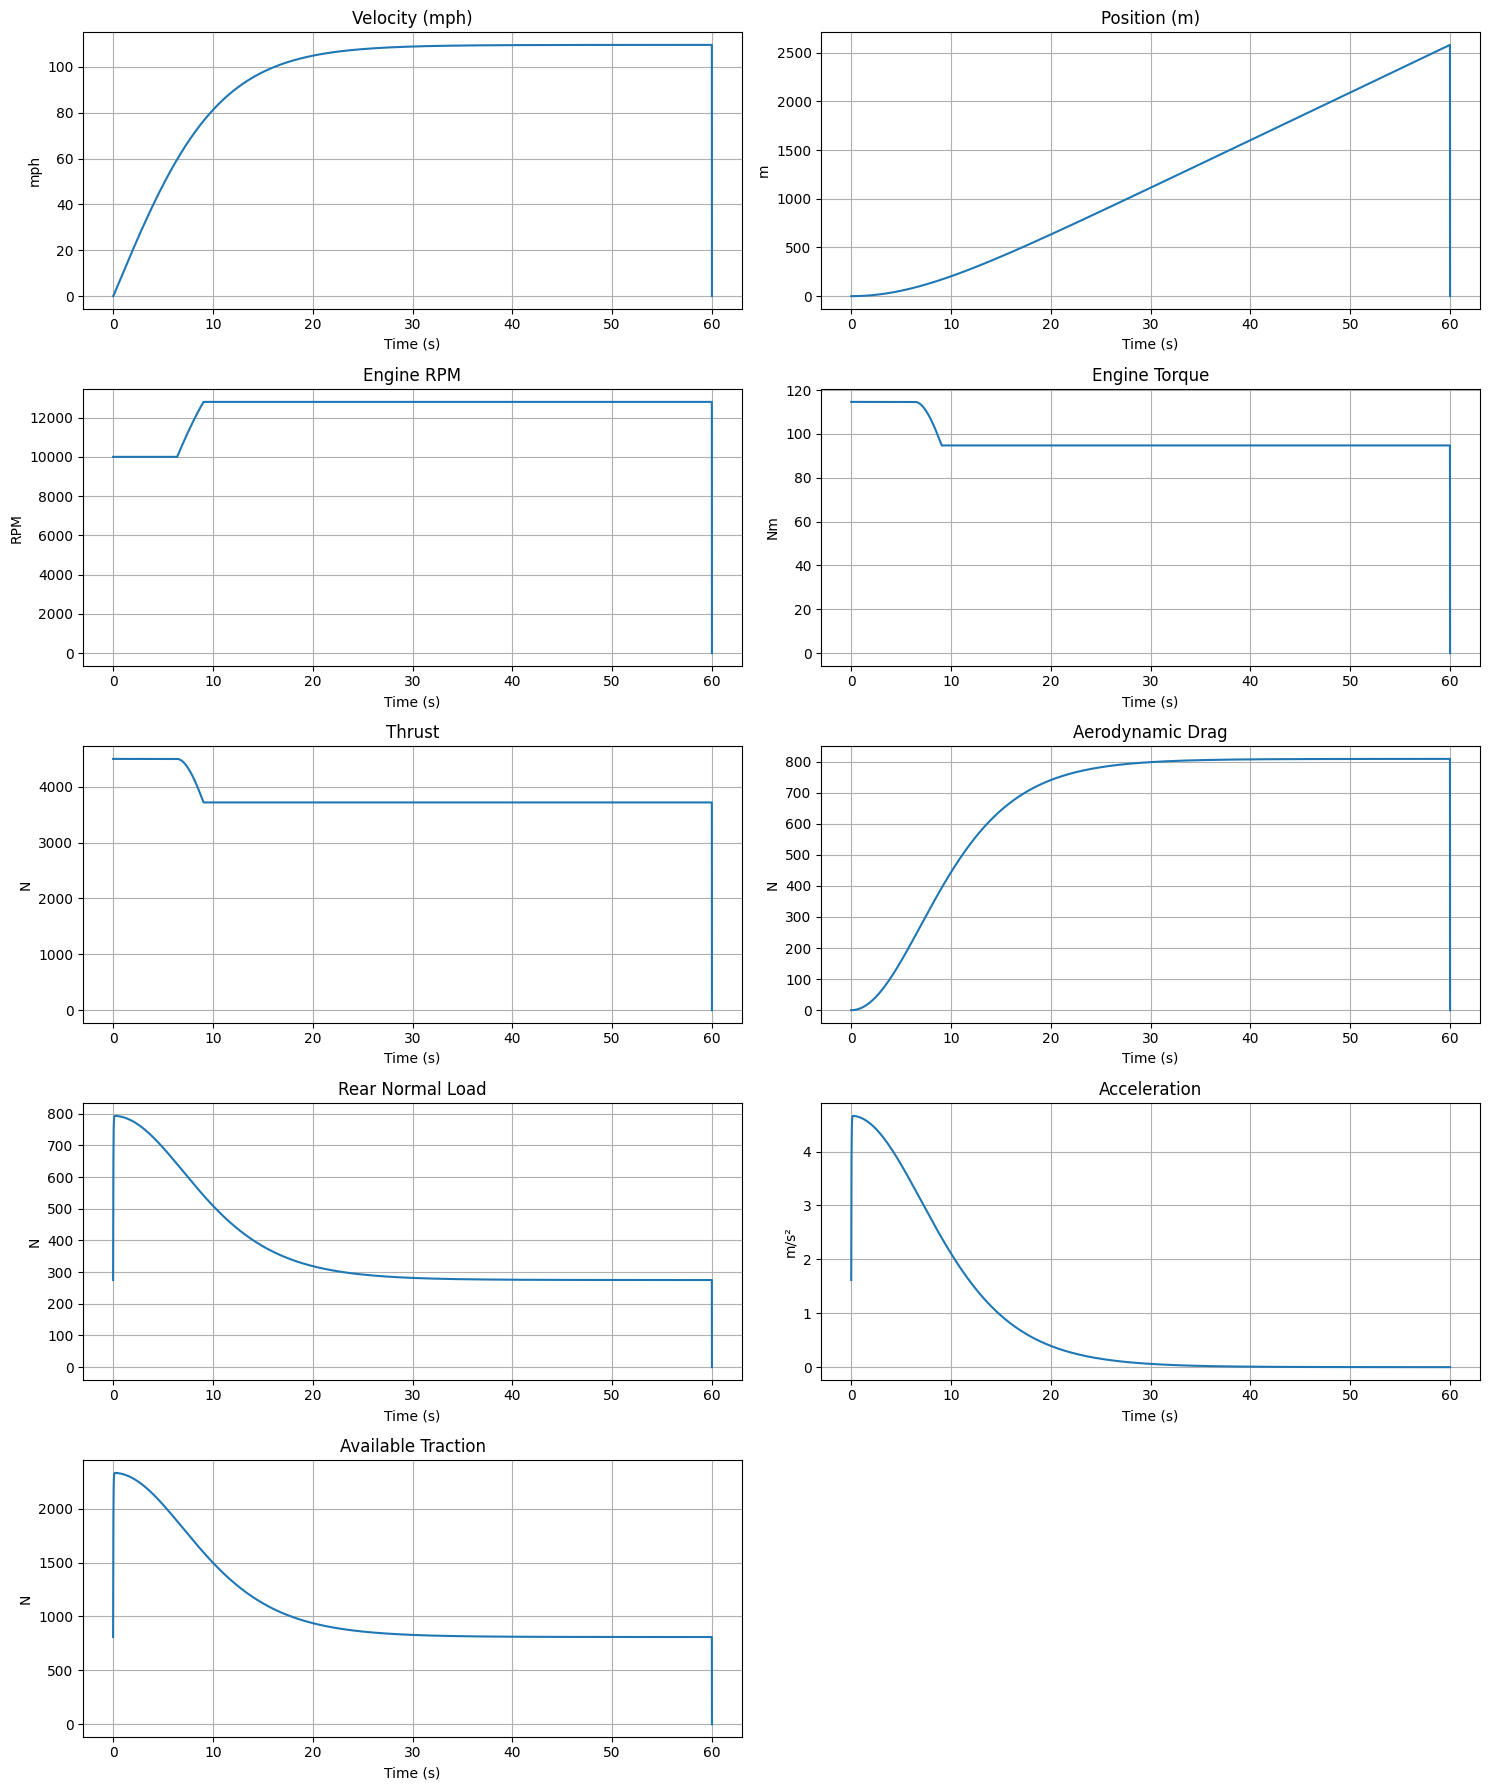

In [124]:
plot_simulation_results(time, vel, pos, rpm, torque, thrust, drag, rear_NL, accel, traction)

In [125]:
#max speed in each gear
top_speeds = np.zeros(6)
top_speeds2 = np.zeros(6)
for i in range(6):
    top_speeds[i] = 12800 / gear[i] / final_drive * (.6*np.pi) * 60 / 1609
    top_speeds2[i] = speed_for_rpm_gear(12800,i) * 2.23694

print(top_speeds)
print(top_speeds2)

[ 76.40794564  98.23878725 116.44570915 131.03418134 143.87855332
 153.48731435]
[ 76.39173994  98.21795135 116.42101166 131.00638972 143.84803748
 153.45476054]
